<a href="https://colab.research.google.com/github/TottiPuc/Face_Detection/blob/master/Face_detection_Detectron2_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deteccción de Rostros


In [0]:
#!pip install watermark

In [0]:
#versión de python
from platform import python_version
print("Versión de python usada en este notebook: ", python_version())

Versión de python usada en este notebook:  3.7.6


Instalando los paquetes necesarios

In [0]:
!pip install opencv-python==4.2.0.34

In [0]:
!pip install opencv-python-headless==4.2.0.34

In [0]:
#instalar la API COCO que es para el formato de los datos para entrenar los modelos
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-l4fm66_6
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-l4fm66_6
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=279411 sha256=0c943d23e67d05f29ab720f7753e140d08af200b050c47703174f01d3ca27fe4
  Stored in directory: /tmp/pip-ephem-wheel-cache-nqt3ydxg/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools


In [0]:
!pip install torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [0]:
!pip install cython 

In [0]:
!pip install --ignore-installed pyyaml==5.1

Processing /home/cdayan/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b/PyYAML-5.1-cp37-cp37m-linux_x86_64.whl


In [0]:
# Clon del repositorio  Detectron2
#!git clone https://github.com/facebookresearch/detectron2.git detectron2_repo

In [0]:
# Instalar  Detectron2
!pip install -e detectron2_repo

Obtaining file:///home/cdayan/FIA/DLF/miniprojects_deep_learning_frameworks/1-Mini-Projeto/detectron2_repo
  Found existing installation: detectron2 0.1.1
    Uninstalling detectron2-0.1.1:
      Successfully uninstalled detectron2-0.1.1
  Running setup.py develop for detectron2


Despues de instalar todas la dependecias se debe reiniciar el kernel del notebook.

In [0]:
#librerias principales
import os
import cv2
import glob
import json
import ntpath
import random
import urllib
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image

#torch
import torch
import torchvision

#Detectron 2
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
setup_logger()

#graficas e imágenes
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Formato de las imágens
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# Semilla
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [0]:
# Versiones de los paquetes usados en este notebook
%reload_ext watermark
%watermark -a "Christian Dayan Arcos Gordillo" --iversions

torchvision 0.5.0+cu100
seaborn     0.9.0
cv2.cv2     4.2.0
pandas      0.25.3
detectron2  0.1.1
PIL.Image   7.0.0
json        2.0.9
torch       1.4.0+cu100
numpy       1.17.4
Christian Dayan Arcos Gordillo


Cargando el conjunto de datos de entrenamiento disponible en [kaggle](https://www.kaggle.com/dataturks/face-detection-in-images) usado para Face Detection in Images. El dataset contiene un diccionario con las anotaciones de los rostros de cada imágen en archivo JSON

In [0]:
#from google.colab import files
#files.upload()

In [0]:

#Cargando archivo JSON
faces_df = pd.read_json('dicionarios/face_detection.json', lines = True)

cada linea del dataset contiene una anotación de rostro unica 

In [0]:
faces_df.head()

content  \
0  http://com.dataturks.a96-i23.open.s3.amazonaws...   
1  http://com.dataturks.a96-i23.open.s3.amazonaws...   
2  http://com.dataturks.a96-i23.open.s3.amazonaws...   
3  http://com.dataturks.a96-i23.open.s3.amazonaws...   
4  http://com.dataturks.a96-i23.open.s3.amazonaws...   

                                          annotation  extras  
0  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
1  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
2  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
3  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
4  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN

##Pre-procesamiento del dataset
Como se puede observar el dataset esta compuesto por link que contiene las imágenes. Entonces se descargan las imágenes y se normalizan las anotaciones para facilitar el uso con detectron2

In [0]:
#crear directorio para guardar las imágenes
os.makedirs("faces", exist_ok = True)

In [0]:
#lista para recibir los datos
dataset =[]

In [0]:
faces_df.shape

(409, 3)

El dataset contiene 409 imágenes de tres canales

In [0]:
#Loop para descargar las imágenes
for index, row in tqdm(faces_df.iterrows(), total = faces_df.shape[0]):

  #cargamos la url de cada imágen 
  img = urllib.request.urlopen(row["content"])

  #se abre la imágens
  img = Image.open(img)

  #Convertir a colores RGB
  img = img.convert('RGB')

  #definir el nombre de la imágen
  image_name = f'face_{index}.jpeg'

  #Guardar la imágen en el folder faces
  img.save(f'faces/{image_name}', "JPEG")

  #obtener las anotaciones (etiquetas de la imágens)
  annotations = row['annotation']

  #Loop para recorrer las anotaciones de cada imágen

  for an in annotations:

    #Diccionario
    data = {}

    #ancho, alto y puntos de la imágen 
    width = an['imageWidth']
    height = an['imageHeight']
    points = an['points']

    # creamos el diccionario
    data['file_name'] = image_name
    data['width'] = width
    data['height'] = height

    #Coordenadas de las esquinas de cada cuadro que enmarca los rostros de cada imágen
    data["x_min"] = int(round(points[0]["x"] * width))
    data["y_min"] = int(round(points[0]["y"] * height))
    data["x_max"] = int(round(points[1]["x"] * width))
    data["y_max"] = int(round(points[1]["y"] * height))

    # nombre de la clase
    data['class_name'] = 'face'

    #Grabar los resultados en la lista
    dataset.append(data)

100%|██████████| 409/409 [03:23<00:00,  2.01it/s]


Se convierte la lista de imagenes creada anteriormente en un datafram

In [0]:
df = pd.DataFrame(dataset)

In [0]:
df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face
2  face_1.jpeg   1280     697    903    162    985    252       face
3  face_2.jpeg    460     240    216     12    279     80       face
4  face_2.jpeg    460     240    289      2    343     74       face

In [0]:
#shape del dataframe
print(df.file_name.unique().shape[0],df.shape[0])

409 1132


Se puede ver que existen 409 imagenes diferentes  pero un total de 1132 anotaciones 

In [0]:
#Grabando las anotaciones
df.to_csv('dicionarios/annotations.csv', header = True, index = None)

##Análisis Exploratorio de las Imágenes
Los siguientes son algunos ejemplos de datos y sus anotaciones, Se usará OpenCV para cargar las imágenes, adicionar los marcos delimitadores y ponerlas en la dimension adecuada. 

In [0]:
def annotate_image(annotations, resize = True):

  #nombre del archivo
  file_name = annotations.file_name.to_numpy()[0] # se convierte los string de la misma categoria a un array y se elije el primero
  #print(file_name)

  #lectura de la imágen con openCV
  img = cv2.cvtColor(cv2.imread(f'faces/{file_name}'), cv2.COLOR_BGR2RGB)

  #Busca las anotaciones
  for i, a in annotations.iterrows():    
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 2)
    #print(a.x_min)
    #print(a.y_min)
    #print(a.x_max)
    #print(a.y_max)

  #redimencionar la imágen caso sea necesario
  if not resize:
    return img

  #retornar la imágen
  return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

(-0.5, 499.5, 499.5, -0.5)

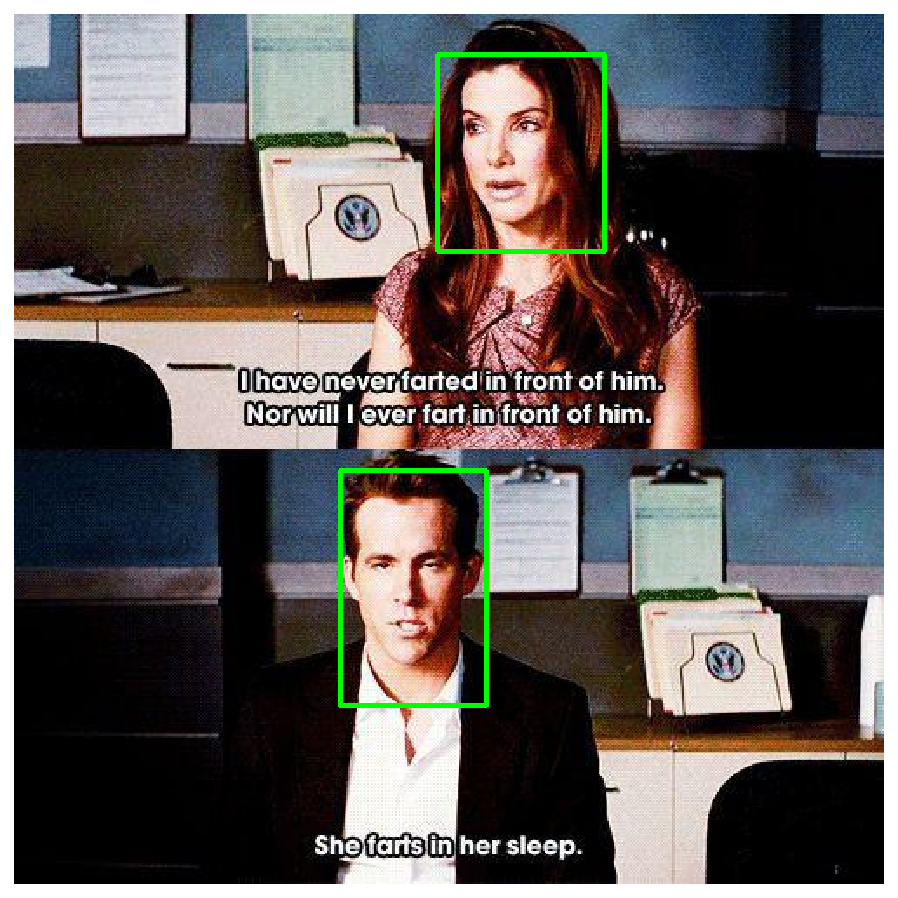

In [0]:
#Visualizar una imágen con sus anotaciones
img_df = df[df.file_name == df.file_name.unique()[5]]
img = annotate_image(img_df,resize=False)
plt.imshow(img)
plt.axis('off')

In [0]:
#Obtener ejemplos de las imágenes
sample_images = [annotate_image(df[df.file_name == f]) for f in df.file_name.unique()[:10]]
sample_images = torch.as_tensor(sample_images)

In [0]:
sample_images.shape

torch.Size([10, 384, 384, 3])

In [0]:
#Ajustamos el shape
sample_images = sample_images.permute(0, 3, 1, 2)

In [0]:
sample_images.shape

torch.Size([10, 3, 384, 384])

(-0.5, 1931.5, 773.5, -0.5)

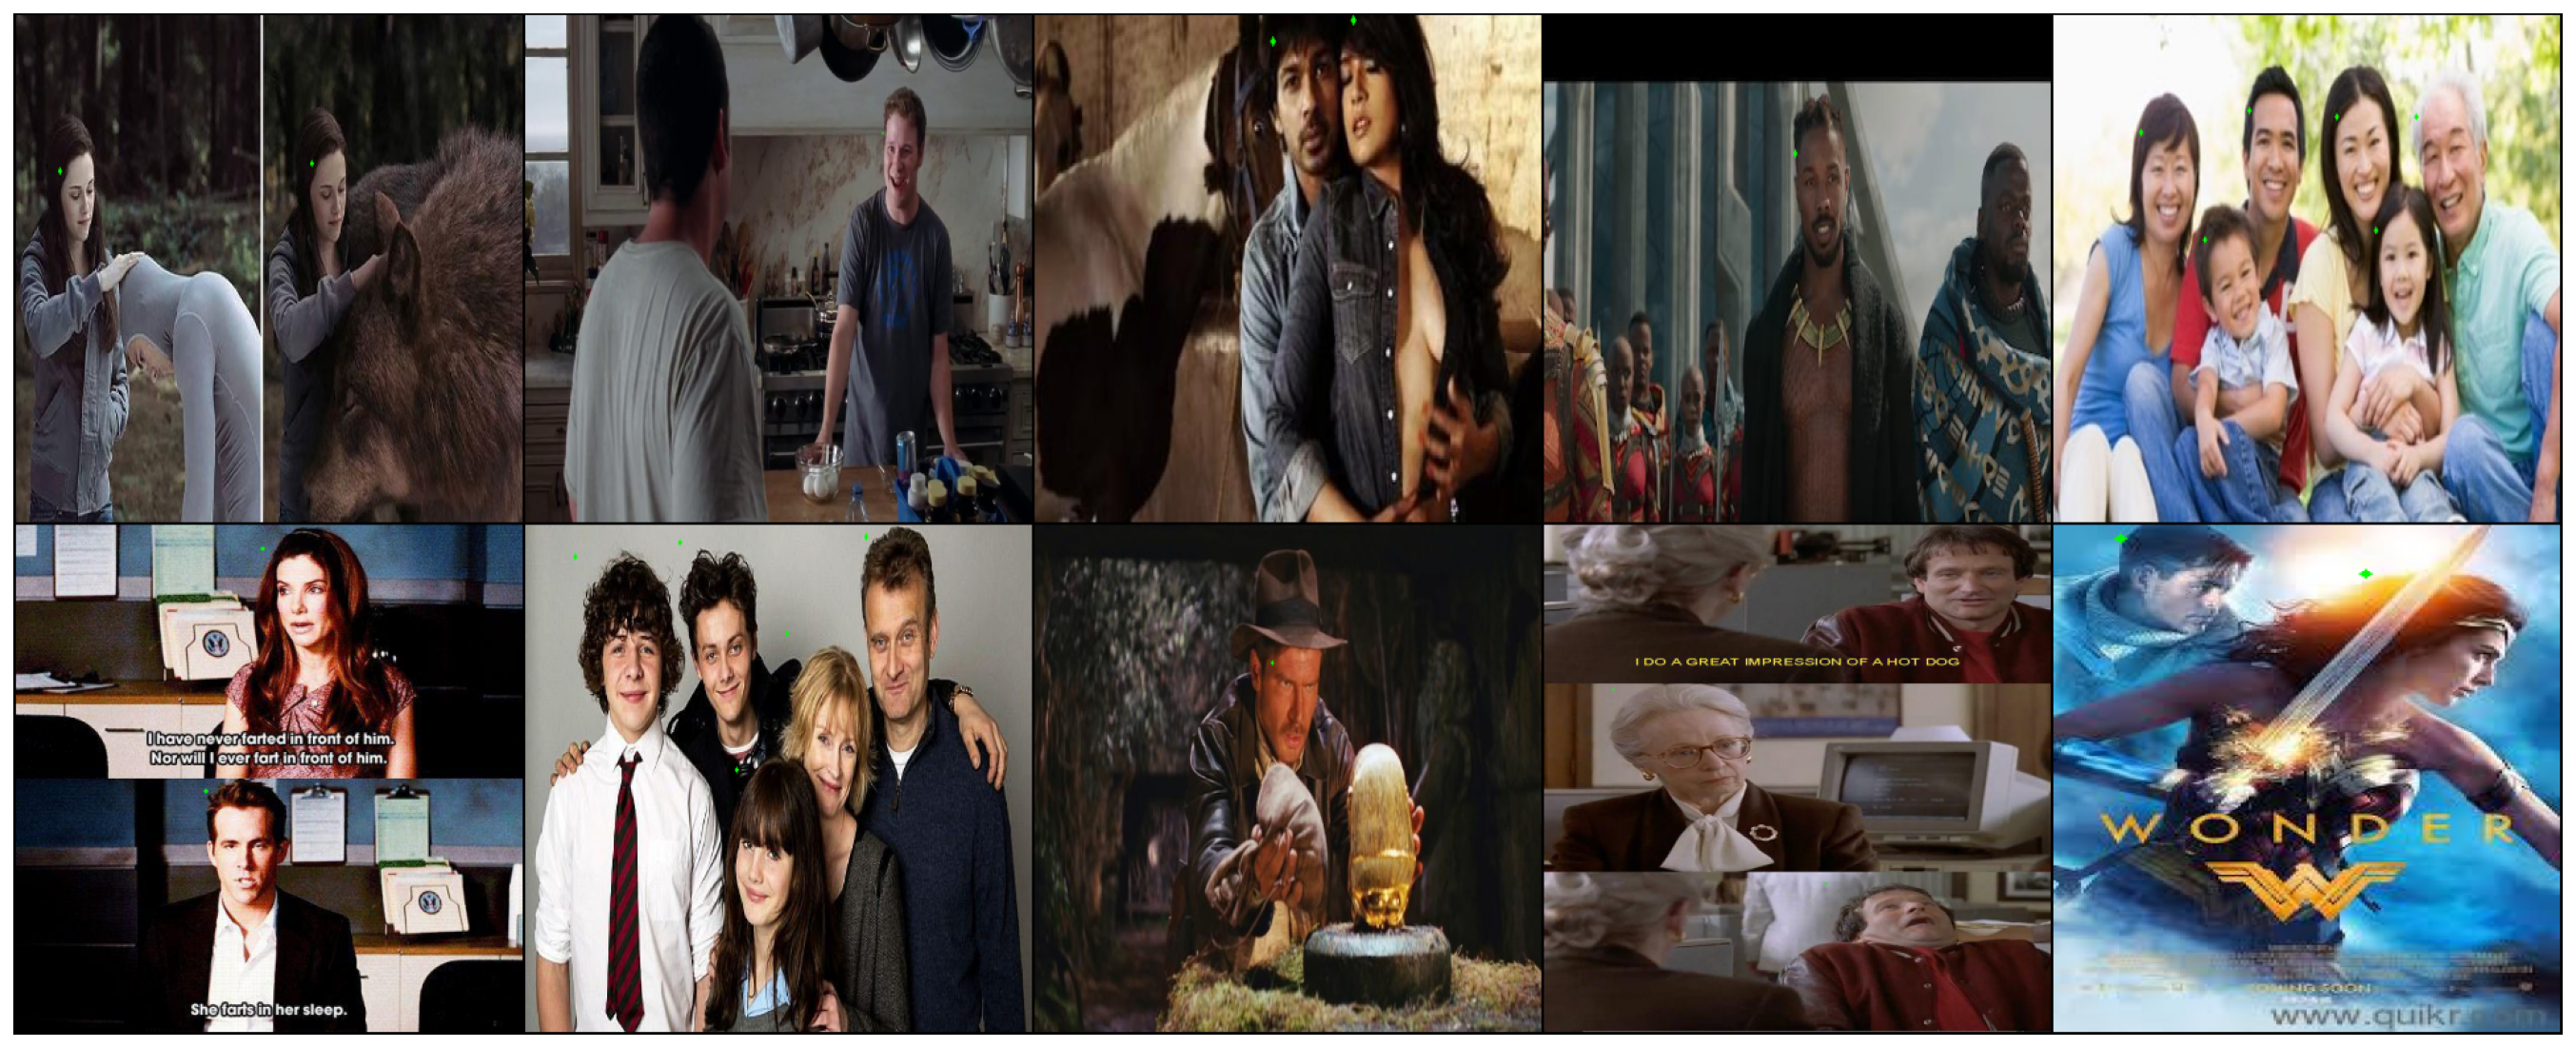

In [0]:
# Plot de varias imágenes en grid
plt.figure(figsize = (24, 12))
grid_img = torchvision.utils.make_grid(sample_images, nrow = 5)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')

##Preparando los datos

In [0]:
#Cargando las anotaciones
df = pd.read_csv('dicionarios/annotations.csv')

In [0]:
#Diametro de los imagenes
IMAGES_PATH = f'faces'

In [0]:
#Retornar las imágenes únicas 
unique_files = df.file_name.unique()

Preparando los datos de entreno y teste

In [0]:
train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.95), replace = False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

In [0]:
train_df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face
2  face_1.jpeg   1280     697    903    162    985    252       face
3  face_2.jpeg    460     240    216     12    279     80       face
4  face_2.jpeg    460     240    289      2    343     74       face

In [0]:
#obteniendo las clases
classes = df.class_name.unique().tolist()

In [0]:
classes

['face']

##Formato de las imagenes para que puedan ser usadas por Detectron 

In [0]:
#Funcion para colocar las imágenes en formato COCO
def create_dataset_dicts(df, classes):
    
    # Lista para los dicionarios de clase
    dataset_dicts = []
        
    # Loop por cada imagen
    for image_id, img_name in enumerate(df.file_name.unique()):

        # Diccionario
        record = {}

        # Imagen
        image_df = df[df.file_name == img_name]

        # Camino
        file_path = f'{IMAGES_PATH}/{img_name}'
        
        # Datos de la imagen
        record["file_name"] = file_path
        record["image_id"] = image_id
        record["height"] = int(image_df.iloc[0].height)
        record["width"] = int(image_df.iloc[0].width)

        # Objetos
        objs = []
    
        # Loop
        for _, row in image_df.iterrows():

            # Coordenadas
            xmin = int(row.x_min)
            ymin = int(row.y_min)
            xmax = int(row.x_max)
            ymax = int(row.y_max)

            poly = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
            poly = list(itertools.chain.from_iterable(poly))

            obj = {"bbox": [xmin, ymin, xmax, ymax], 
                   "bbox_mode": BoxMode.XYXY_ABS, 
                   "segmentation": [poly], 
                   "category_id": classes.index(row.class_name), 
                   "iscrowd": 0}
    
            objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
    return dataset_dicts

In [0]:
# Registrando el conjunto de datos
for d in ["train", "val"]:
    DatasetCatalog.register("faces_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
    MetadataCatalog.get("faces_" + d).set(thing_classes=classes)

In [0]:
# Generando los metadados
statement_metadata = MetadataCatalog.get("faces_train")

In [0]:
# Classe para entrenar y evaluar el modelo
class treinaModelo(DefaultTrainer):
  
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder = None):

        if output_folder is None:
            os.makedirs("eval", exist_ok = True)
            output_folder = "eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

Los resultados se guardan en la carpeta eval

Usaremos el modelo pre entrenado Mask R-CNN X101-FPN que fue pre entrenado en el dataset COCO y alcanza un desempeño muy bueno

In [0]:
# Inicia el archivo de configuración
cfg = get_cfg()

# Cargar el archivo de configuración
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))

# Cargar los pesos del modelo pre-entrenado
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

In [0]:
# Especificamos los conjuntos de datos (los registramos) que usaremos para entrenamiento y evaluación
cfg.DATASETS.TRAIN = ("faces_train",)
cfg.DATASETS.TEST = ("faces_val",)
cfg.DATALOADER.NUM_WORKERS = 4

In [0]:
# Para el optimizador, definiremos algunos valores. 
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.TEST.EVAL_PERIOD = 500

In [0]:
# Verificamos si el diretorio de salida existe
os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)

Entrenamos el modelo

In [0]:
# Cargamos las configuraciones
trainer = treinaModelo(cfg)

[04/09 19:45:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[04/09 19:45:18 d2.data.build]: Removed 0 images with no usable annotations. 1 images left.
[04/09 19:45:18 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    face    | 2            |
|            |              |
[04/09 19:45:18 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[04/09 19:45:18 d2.data.common]: Serialized dataset takes 0.00 MiB
[04/09 19:45:18 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/09 19:45:18 d2.data.build]: Using training sampler TrainingSampler


In [0]:
# Vamos iniciar el entrenamiento de cero e no de donde paro
trainer.resume_or_load(resume = False)

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


In [0]:
#Entrenamiento
trainer.train()

[04/09 19:45:34 d2.engine.train_loop]: Starting training from iteration 0
[04/09 19:45:56 d2.utils.events]:  eta: 0:26:38  iter: 19  total_loss: 1.867  loss_cls: 0.586  loss_box_reg: 0.491  loss_mask: 0.689  loss_rpn_cls: 0.114  loss_rpn_loc: 0.022  time: 1.0767  data_time: 0.0151  lr: 0.000020  max_mem: 10492M
[04/09 19:46:18 d2.utils.events]:  eta: 0:26:22  iter: 39  total_loss: 1.910  loss_cls: 0.506  loss_box_reg: 0.654  loss_mask: 0.652  loss_rpn_cls: 0.096  loss_rpn_loc: 0.018  time: 1.0786  data_time: 0.0074  lr: 0.000040  max_mem: 10492M
[04/09 19:46:40 d2.utils.events]:  eta: 0:26:03  iter: 59  total_loss: 1.928  loss_cls: 0.433  loss_box_reg: 0.840  loss_mask: 0.573  loss_rpn_cls: 0.050  loss_rpn_loc: 0.018  time: 1.0834  data_time: 0.0066  lr: 0.000060  max_mem: 10492M
[04/09 19:47:02 d2.utils.events]:  eta: 0:25:55  iter: 79  total_loss: 1.691  loss_cls: 0.334  loss_box_reg: 0.864  loss_mask: 0.472  loss_rpn_cls: 0.023  loss_rpn_loc: 0.017  time: 1.0897  data_time: 0.0069  

[04/09 19:55:26 d2.evaluation.coco_evaluation]: Note that some metrics cannot be computed.
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

[04/09 20:05:06 d2.utils.events]:  eta: 0:10:32  iter: 979  total_loss: 0.123  loss_cls: 0.019  loss_box_reg: 0.078  loss_mask: 0.024  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 1.1917  data_time: 0.0075  lr: 0.000979  max_mem: 10492M
[04/09 20:05:30 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[04/09 20:05:30 d2.data.common]: Serialized dataset takes 0.00 MiB
[04/09 20:05:30 d2.evaluation.evaluator]: Start inference on 1 images
[04/09 20:05:30 d2.evaluation.evaluator]: Inference done 1/1. 0.2873 s / img. ETA=0:00:00
[04/09 20:05:30 d2.evaluation.evaluator]: Total inference time: 0:00:00.341267 (0.341267 s / img per device, on 1 devices)
[04/09 20:05:30 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.287270 s / img per device, on 1 devices)
[04/09 20:05:30 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/09 20:05:30 d2.evaluation.coco_evaluation]: Saving results to eval/coco_instances_result

[04/09 20:11:08 d2.utils.events]:  eta: 0:04:28  iter: 1279  total_loss: 0.046  loss_cls: 0.013  loss_box_reg: 0.015  loss_mask: 0.018  loss_rpn_cls: 0.000  loss_rpn_loc: 0.000  time: 1.1946  data_time: 0.0073  lr: 0.000050  max_mem: 10492M
[04/09 20:11:32 d2.utils.events]:  eta: 0:04:04  iter: 1299  total_loss: 0.045  loss_cls: 0.012  loss_box_reg: 0.014  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.000  time: 1.1949  data_time: 0.0071  lr: 0.000050  max_mem: 10492M
[04/09 20:11:57 d2.utils.events]:  eta: 0:03:40  iter: 1319  total_loss: 0.043  loss_cls: 0.012  loss_box_reg: 0.014  loss_mask: 0.016  loss_rpn_cls: 0.000  loss_rpn_loc: 0.000  time: 1.1952  data_time: 0.0071  lr: 0.000050  max_mem: 10492M
[04/09 20:12:21 d2.utils.events]:  eta: 0:03:15  iter: 1339  total_loss: 0.044  loss_cls: 0.011  loss_box_reg: 0.015  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.000  time: 1.1954  data_time: 0.0072  lr: 0.000050  max_mem: 10492M
[04/09 20:12:45 d2.utils.events]:  e

#Cargando el modelo

In [0]:
# Diretório y nombre del modelo
cfg.MODEL.WEIGHTS = os.path.join("output", "model_final.pth")

# Define o threshold de teste para el modelo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75

# Guardar el predictor
preditor = DefaultPredictor(cfg)

##Evaluando el modelo

La evaluacion de este modelo se hace con la metrica IoU (Interseccion sobe Union) que mide la sobreposición entre dos limites.

In [0]:
# Resultado de la  avaluación
evaluator = COCOEvaluator("faces_val", cfg, False, output_dir = "./output/")
val_loader = build_detection_test_loader(cfg, "faces_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/09 20:20:43 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[04/09 20:20:43 d2.data.common]: Serialized dataset takes 0.00 MiB
[04/09 20:20:43 d2.evaluation.evaluator]: Start inference on 1 images
[04/09 20:20:43 d2.evaluation.evaluator]: Inference done 1/1. 0.1390 s / img. ETA=0:00:00
[04/09 20:20:43 d2.evaluation.evaluator]: Total inference time: 0:00:00.192468 (0.192468 s / img per device, on 1 devices)
[04/09 20:20:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.138984 s / img per device, on 1 devices)
[04/09 20:20:43 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/09 20:20:43 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[04/09 20:20:43 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': nan}),
             ('segm',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': nan})])

#Detección Facial
Evaluamos el modelo con nuevas imágenes

In [0]:
# Define el directorio
os.makedirs("annotated_results", exist_ok = True)

In [0]:
# Obtiene las imágenes
test_image_paths = test_df.file_name.unique()

In [0]:
# Aqui hacemos detección para cada imágen de teste
for teste_image in test_image_paths:
    file_path = f'{IMAGES_PATH}/{teste_image}'
    im = cv2.imread(file_path)
    outputs = preditor(im)
    v = Visualizer(im[:, :, ::-1], metadata = statement_metadata, scale = 1., instance_mode = ColorMode.IMAGE)
    instances = outputs["instances"].to("cpu")
    instances.remove('pred_masks')
    v = v.draw_instance_predictions(instances)
    result = v.get_image()[:, :, ::-1]
    file_name = ntpath.basename(teste_image)
    write_res = cv2.imwrite(f'annotated_results/{file_name}', result)

In [0]:
annotated_images = [f'annotated_results/{f}' for f in test_df.file_name.unique()]

(-0.5, 930.5, 523.5, -0.5)

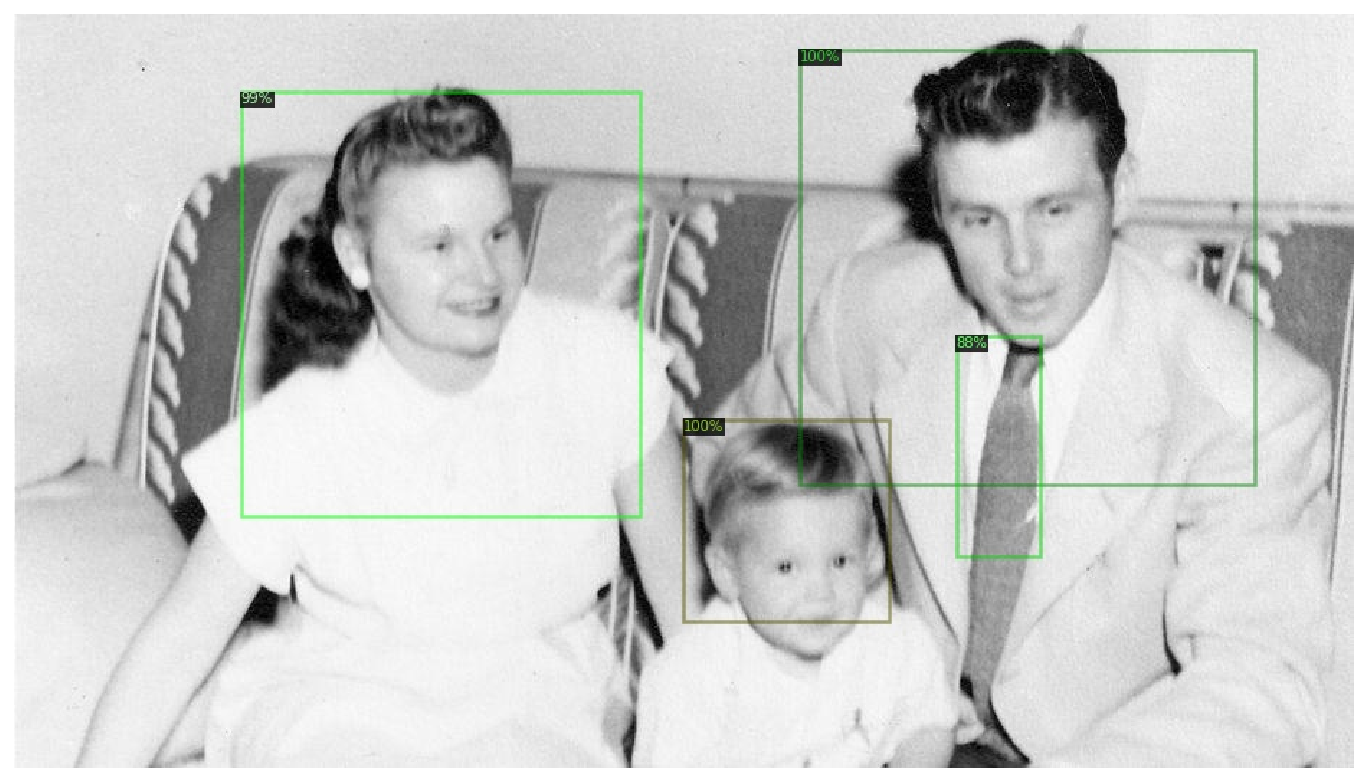

In [0]:
# Detectando rostros en imágenes
img = cv2.cvtColor(cv2.imread(annotated_images[5]), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

(-0.5, 599.5, 392.5, -0.5)

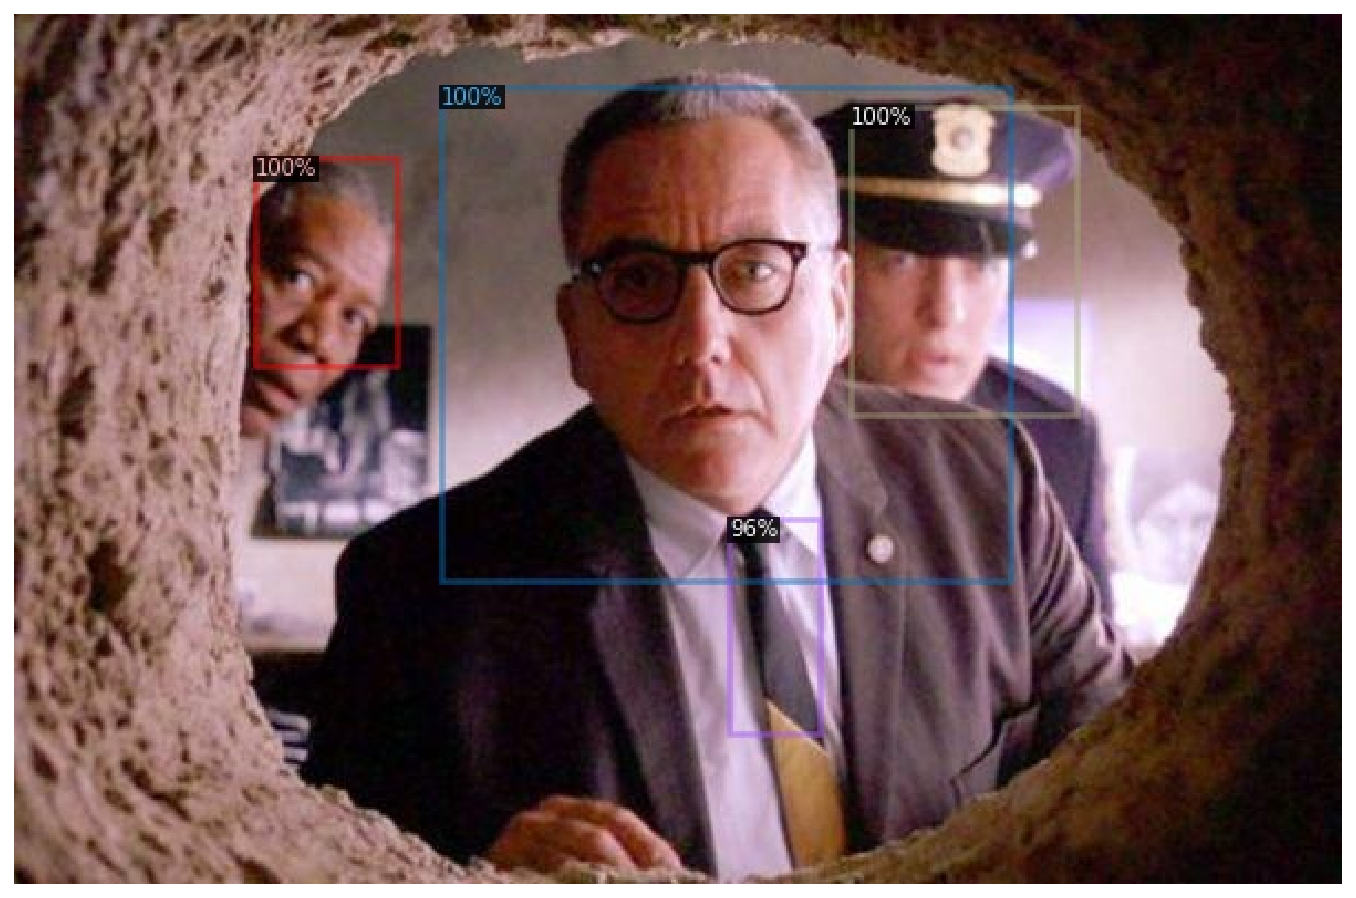

In [0]:
img = cv2.cvtColor(cv2.imread(annotated_images[3]), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')